# IDA and EDA Analysis

## Datasets


In [7]:
#imports
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [17]:
df = pd.read_csv('../data/df_cleaned.csv')

## Visualizations

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# For text analysis
from wordcloud import WordCloud
from collections import Counter
import re

In [16]:
# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Color palettes
COLORS = {
    'positive': '#2ecc71',
    'neutral': '#95a5a6', 
    'negative': '#e74c3c',
    'reddit': '#FF4500',
    'youtube': '#FF0000'
}

In [19]:
df['created_at'] = pd.to_datetime(df['created_at'])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (4,) and arg 3 with shape (5,).

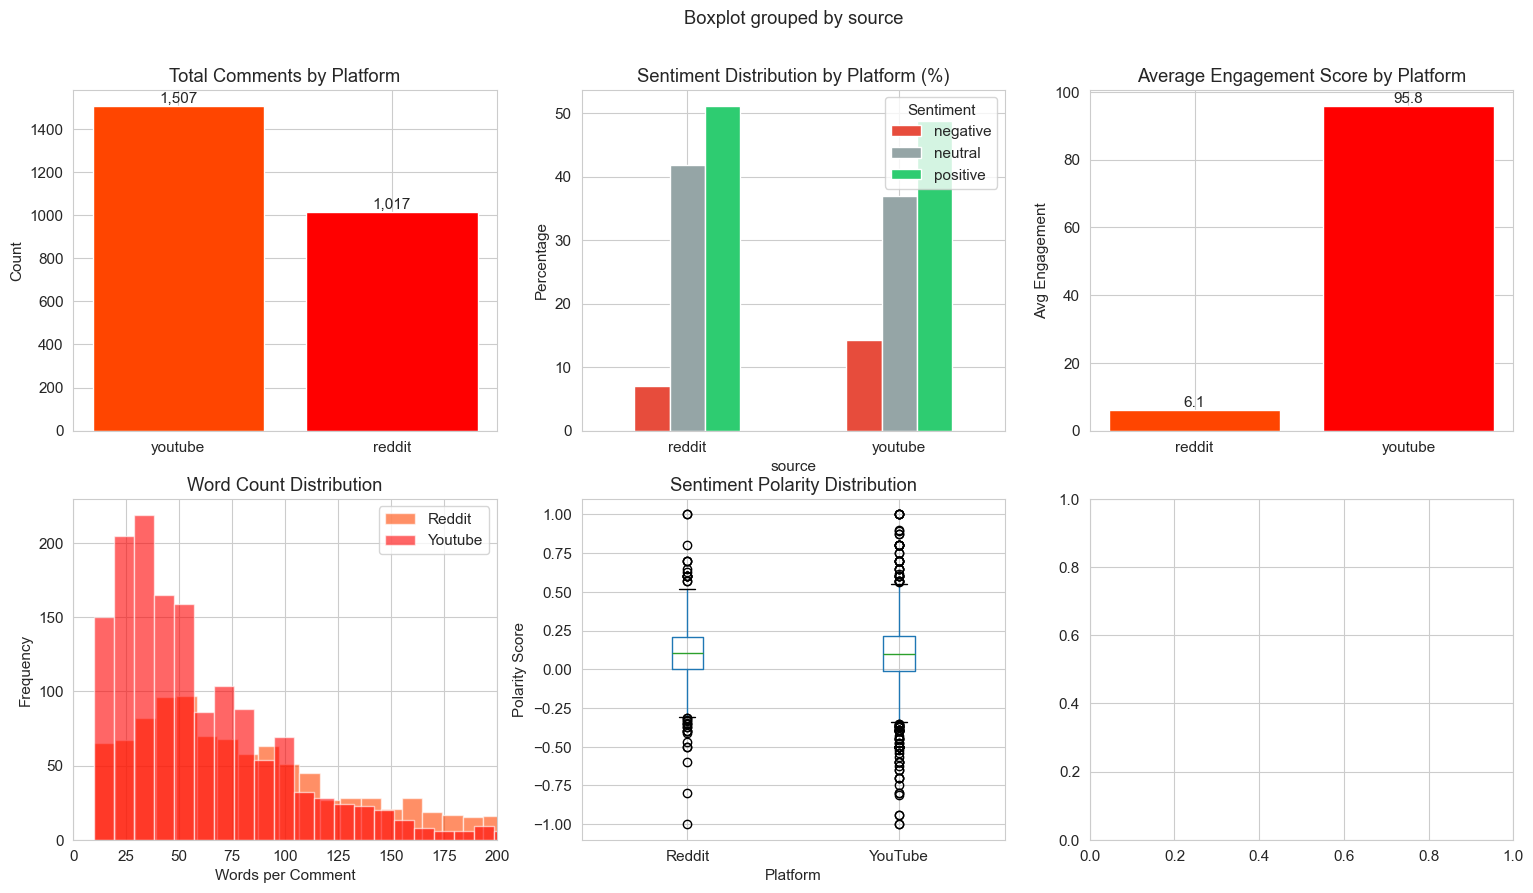

In [23]:
# %% [markdown]
## 4. VISUALIZATION 1: Platform Comparison Dashboard
# **Streamlit-Ready**: ⭐⭐⭐⭐⭐ (Great overview, tells multiple stories)

# %%
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Platform Comparison: Reddit vs YouTube', fontsize=16, fontweight='bold')

# 1. Comment count by platform
platform_counts = df['source'].value_counts()
axes[0, 0].bar(platform_counts.index, platform_counts.values, 
               color=[COLORS['reddit'], COLORS['youtube']])
axes[0, 0].set_title('Total Comments by Platform')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(platform_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# 2. Sentiment distribution by platform
sentiment_platform = pd.crosstab(df['source'], df['sentiment_label'], normalize='index') * 100
sentiment_platform.plot(kind='bar', ax=axes[0, 1], 
                        color=[COLORS['negative'], COLORS['neutral'], COLORS['positive']])
axes[0, 1].set_title('Sentiment Distribution by Platform (%)')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].legend(title='Sentiment')

# 3. Average engagement by platform
engagement_by_platform = df.groupby('source')['engagement_score'].mean()
axes[0, 2].bar(engagement_by_platform.index, engagement_by_platform.values,
               color=[COLORS['reddit'], COLORS['youtube']])
axes[0, 2].set_title('Average Engagement Score by Platform')
axes[0, 2].set_ylabel('Avg Engagement')
for i, v in enumerate(engagement_by_platform.values):
    axes[0, 2].text(i, v, f'{v:.1f}', ha='center', va='bottom')

# 4. Word count distribution by platform
for source in df['source'].unique():
    data = df[df['source'] == source]['word_count']
    axes[1, 0].hist(data, bins=30, alpha=0.6, label=source.capitalize(),
                    color=COLORS[source])
axes[1, 0].set_title('Word Count Distribution')
axes[1, 0].set_xlabel('Words per Comment')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 200)

# 5. Sentiment polarity by platform
df.boxplot(column='sentiment_polarity', by='source', ax=axes[1, 1])
axes[1, 1].set_title('Sentiment Polarity Distribution')
axes[1, 1].set_xlabel('Platform')
axes[1, 1].set_ylabel('Polarity Score')
plt.sca(axes[1, 1])
plt.xticks([1, 2], ['Reddit', 'YouTube'])

# 6. Top communities by platform
top_reddit = df[df['source'] == 'reddit']['platform_community'].value_counts().head(5)
top_youtube = df[df['source'] == 'youtube']['platform_community'].value_counts().head(5)

y_pos = np.arange(5)
axes[1, 2].barh(y_pos, top_reddit.values, alpha=0.8, color=COLORS['reddit'], label='Reddit')
axes[1, 2].set_yticks(y_pos)
axes[1, 2].set_yticklabels([c[:20] for c in top_reddit.index])
axes[1, 2].set_xlabel('Number of Comments')
axes[1, 2].set_title('Top 5 Communities (Reddit)')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.savefig('platform_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Platform comparison dashboard created")

# %% [markdown]
## 5. VISUALIZATION 2: Sentiment Timeline (Interactive)
# **Streamlit-Ready**: ⭐⭐⭐⭐⭐ (Shows trends, interactive, tells a story)

# %%
# Aggregate sentiment by date and platform
df['date'] = df['created_at'].dt.date
daily_sentiment = df.groupby(['date', 'source', 'sentiment_label']).size().reset_index(name='count')

# Create interactive line plot
fig = px.line(daily_sentiment, x='date', y='count', color='sentiment_label',
              facet_row='source', 
              color_discrete_map=COLORS,
              title='Sentiment Trends Over Time by Platform',
              labels={'count': 'Number of Comments', 'date': 'Date', 
                      'sentiment_label': 'Sentiment', 'source': 'Platform'},
              height=700)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Comment Count")
fig.update_layout(hovermode='x unified')

fig.write_html('sentiment_timeline.html')
fig.show()

print("✓ Sentiment timeline created (interactive)")

# %% [markdown]
## 6. VISUALIZATION 3: Polarity vs Subjectivity Scatter
# **Streamlit-Ready**: ⭐⭐⭐⭐ (Shows relationship, interactive)

# %%
# Sample for better performance (if dataset is large)
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

fig = px.scatter(df_sample, 
                 x='sentiment_subjectivity', 
                 y='sentiment_polarity',
                 color='sentiment_label',
                 facet_col='source',
                 color_discrete_map=COLORS,
                 opacity=0.6,
                 hover_data=['word_count', 'engagement_score'],
                 title='Sentiment: Polarity vs Subjectivity',
                 labels={'sentiment_subjectivity': 'Subjectivity',
                        'sentiment_polarity': 'Polarity',
                        'sentiment_label': 'Sentiment'},
                 height=500)

# Add quadrant lines
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=0.5, line_dash="dash", line_color="gray", opacity=0.5)

fig.write_html('polarity_subjectivity.html')
fig.show()

print("✓ Polarity vs subjectivity scatter created")

# %% [markdown]
## 7. VISUALIZATION 4: Engagement Analysis
# **Streamlit-Ready**: ⭐⭐⭐⭐⭐ (Business insights)

# %%
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Engagement Analysis: What Content Resonates?', fontsize=16, fontweight='bold')

# 1. Engagement by sentiment
engagement_sentiment = df.groupby('sentiment_label')['engagement_score'].mean().sort_values(ascending=True)
axes[0, 0].barh(engagement_sentiment.index, engagement_sentiment.values,
                color=[COLORS.get(s, 'gray') for s in engagement_sentiment.index])
axes[0, 0].set_xlabel('Average Engagement Score')
axes[0, 0].set_title('Engagement by Sentiment')
for i, v in enumerate(engagement_sentiment.values):
    axes[0, 0].text(v, i, f' {v:.1f}', va='center')

# 2. Word count vs engagement (scatter with trend)
axes[0, 1].scatter(df['word_count'], df['engagement_log'], alpha=0.3, s=10)
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Engagement (log scale)')
axes[0, 1].set_title('Word Count vs Engagement')
axes[0, 1].set_xlim(0, 300)

# Add trend line
z = np.polyfit(df['word_count'], df['engagement_log'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df['word_count'], p(df['word_count']), "r--", alpha=0.8, linewidth=2)

# 3. Engagement by hour of day
hourly_engagement = df.groupby('hour')['engagement_score'].mean()
axes[1, 0].plot(hourly_engagement.index, hourly_engagement.values, marker='o', linewidth=2)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Engagement')
axes[1, 0].set_title('Engagement by Hour of Day')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(0, 24, 2))

# 4. Top engaged communities
top_communities = df.groupby('platform_community')['engagement_score'].agg(['mean', 'count'])
top_communities = top_communities[top_communities['count'] >= 20]  # At least 20 comments
top_communities = top_communities.sort_values('mean', ascending=False).head(10)

axes[1, 1].barh(range(len(top_communities)), top_communities['mean'])
axes[1, 1].set_yticks(range(len(top_communities)))
axes[1, 1].set_yticklabels([c[:30] for c in top_communities.index])
axes[1, 1].set_xlabel('Average Engagement Score')
axes[1, 1].set_title('Top 10 Most Engaged Communities')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('engagement_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Engagement analysis created")

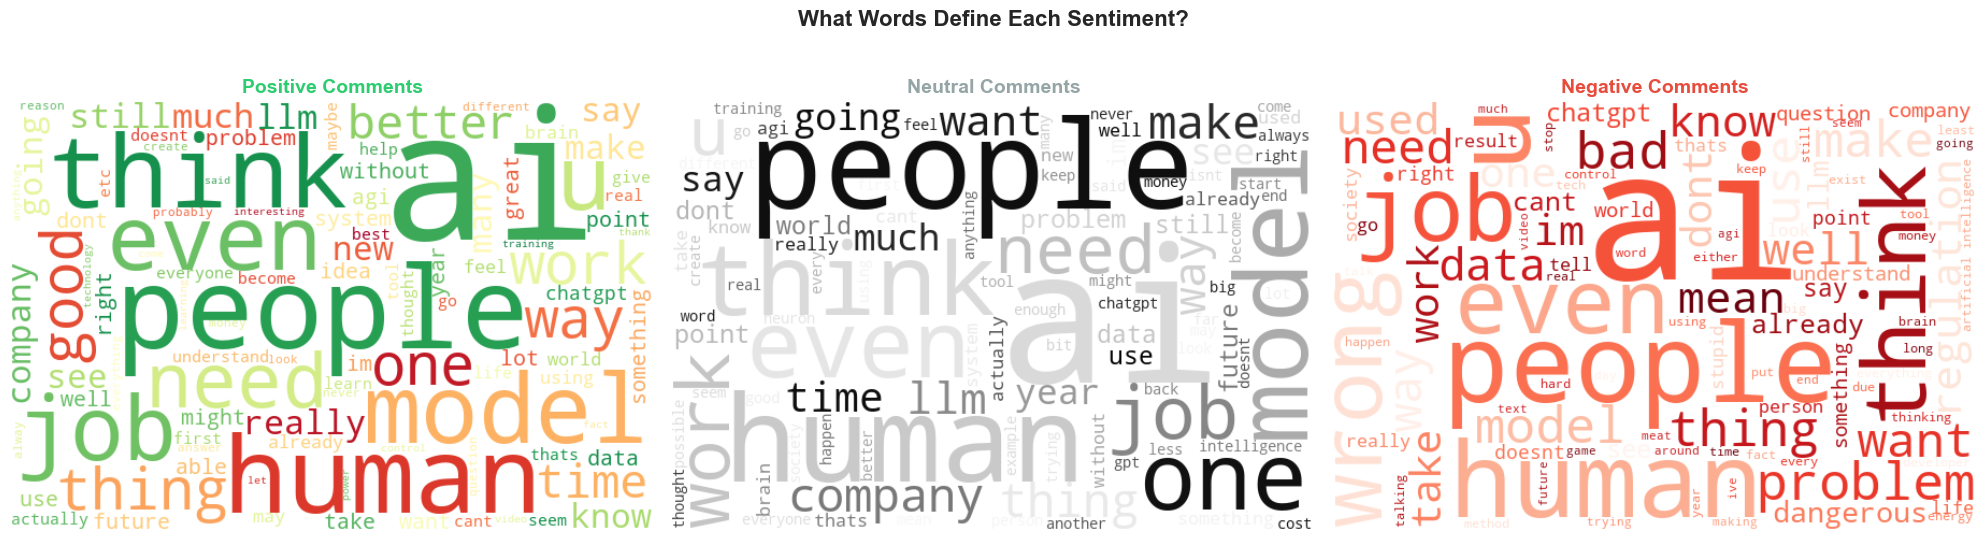

✓ Word clouds created


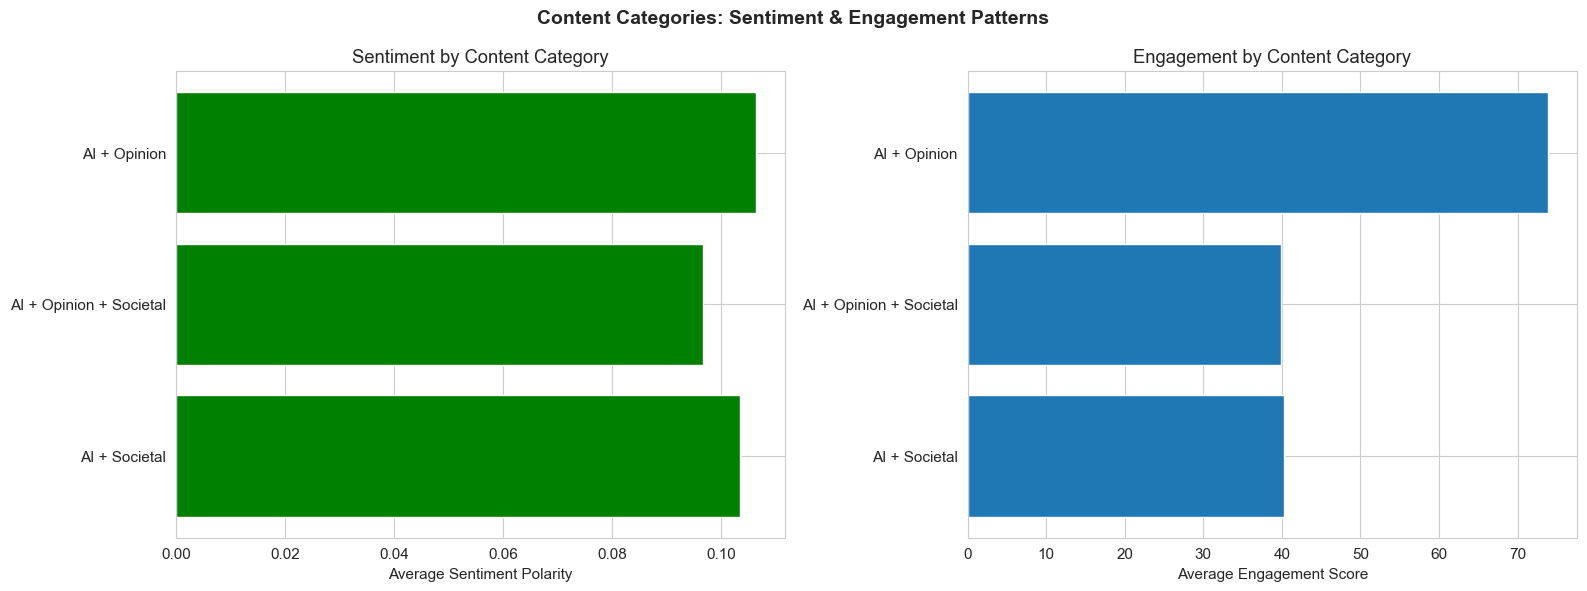

✓ Category analysis created


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [22]:

# %% [markdown]
## 8. VISUALIZATION 5: Word Clouds by Sentiment
# **Streamlit-Ready**: ⭐⭐⭐⭐⭐ (Visual appeal, easy to understand)

# %%
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('What Words Define Each Sentiment?', fontsize=16, fontweight='bold')

sentiments = ['positive', 'neutral', 'negative']

for idx, sentiment in enumerate(sentiments):
    # Get text for this sentiment
    text_data = df[df['sentiment_label'] == sentiment]['text_tfidf'].str.cat(sep=' ')
    
    # Generate word cloud
    wordcloud = WordCloud(width=600, height=400, 
                          background_color='white',
                          colormap='RdYlGn' if sentiment == 'positive' else 
                                   ('Greys' if sentiment == 'neutral' else 'Reds'),
                          max_words=100,
                          relative_scaling=0.5,
                          min_font_size=10).generate(text_data)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment.capitalize()} Comments', 
                       fontsize=14, fontweight='bold',
                       color=COLORS[sentiment])
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('wordclouds_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Word clouds created")

# %% [markdown]
## 9. VISUALIZATION 6: Content Category Heatmap
# **Streamlit-Ready**: ⭐⭐⭐ (Shows patterns)

# %%
# Create category combinations
category_data = df.groupby(['contains_ai', 'contains_opinion', 'contains_societal']).agg({
    'sentiment_polarity': 'mean',
    'engagement_score': 'mean',
    'text': 'count'
}).reset_index()

category_data['category_combo'] = (
    category_data['contains_ai'].astype(str) + '_' +
    category_data['contains_opinion'].astype(str) + '_' +
    category_data['contains_societal'].astype(str)
)

# Rename for clarity
category_labels = {
    'True_True_True': 'AI + Opinion + Societal',
    'True_True_False': 'AI + Opinion',
    'True_False_True': 'AI + Societal',
    'True_False_False': 'AI Only',
    'False_True_True': 'Opinion + Societal',
    'False_True_False': 'Opinion Only',
    'False_False_True': 'Societal Only',
    'False_False_False': 'None'
}

category_data['category_label'] = category_data['category_combo'].map(category_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Content Categories: Sentiment & Engagement Patterns', fontsize=14, fontweight='bold')

# Sort by count
category_data = category_data.sort_values('text', ascending=True)

# 1. Sentiment by category
axes[0].barh(category_data['category_label'], category_data['sentiment_polarity'],
            color=['red' if x < 0 else 'green' for x in category_data['sentiment_polarity']])
axes[0].set_xlabel('Average Sentiment Polarity')
axes[0].set_title('Sentiment by Content Category')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3)

# 2. Engagement by category
axes[1].barh(category_data['category_label'], category_data['engagement_score'])
axes[1].set_xlabel('Average Engagement Score')
axes[1].set_title('Engagement by Content Category')

plt.tight_layout()
plt.savefig('category_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Category analysis created")

# %% [markdown]
## 10. VISUALIZATION 7: Monthly Trends (Interactive)
# **Streamlit-Ready**: ⭐⭐⭐⭐⭐ (Great for storytelling)

# %%
# Aggregate by month
df['year_month'] = df['created_at'].dt.to_period('M').astype(str)

monthly_data = df.groupby(['year_month', 'source']).agg({
    'text': 'count',
    'sentiment_polarity': 'mean',
    'engagement_score': 'mean'
}).reset_index()

monthly_data.columns = ['month', 'source', 'comment_count', 'avg_sentiment', 'avg_engagement']

# Create subplot with 3 metrics
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Monthly Comment Volume', 'Average Sentiment', 'Average Engagement'),
    vertical_spacing=0.1
)

colors_map = {'reddit': COLORS['reddit'], 'youtube': COLORS['youtube']}

for source in monthly_data['source'].unique():
    source_data = monthly_data[monthly_data['source'] == source]
    
    # Comment count
    fig.add_trace(
        go.Scatter(x=source_data['month'], y=source_data['comment_count'],
                  name=source.capitalize(), line=dict(color=colors_map[source]),
                  legendgroup=source),
        row=1, col=1
    )
    
    # Sentiment
    fig.add_trace(
        go.Scatter(x=source_data['month'], y=source_data['avg_sentiment'],
                  name=source.capitalize(), line=dict(color=colors_map[source]),
                  legendgroup=source, showlegend=False),
        row=2, col=1
    )
    
    # Engagement
    fig.add_trace(
        go.Scatter(x=source_data['month'], y=source_data['avg_engagement'],
                  name=source.capitalize(), line=dict(color=colors_map[source]),
                  legendgroup=source, showlegend=False),
        row=3, col=1
    )

fig.update_xaxes(title_text="Month", row=3, col=1)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Polarity", row=2, col=1)
fig.update_yaxes(title_text="Score", row=3, col=1)

fig.update_layout(height=900, title_text="AI Discussion Trends Over Time")
fig.write_html('monthly_trends.html')
fig.show()

print("✓ Monthly trends created")

# %% [markdown]
## 11. VISUALIZATION 8: Correlation Matrix
# **Streamlit-Ready**: ⭐⭐⭐ (Technical audience)

# %%
# Select numeric features for correlation
numeric_features = [
    'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_magnitude',
    'word_count', 'char_count', 'sentence_count', 'avg_word_length',
    'likes', 'replies', 'engagement_score',
    'exclamation_count', 'question_count', 'uppercase_ratio'
]

corr_matrix = df[numeric_features].corr()

# Create correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, 
            square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Correlation matrix created")

# Print top correlations
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs != 1.0]
top_corr = corr_pairs.abs().sort_values(ascending=False).head(10)

print("\n🔗 Top 10 Feature Correlations:")
for idx, (pair, value) in enumerate(top_corr.items(), 1):
    print(f"{idx}. {pair[0]} ↔ {pair[1]}: {corr_pairs[pair]:.3f}")

# %% [markdown]
## 12. VISUALIZATION 9: Top Communities Deep Dive
# **Streamlit-Ready**: ⭐⭐⭐⭐ (Shows community differences)

# %%
# Get top 10 communities by comment count
top_communities_list = df['platform_community'].value_counts().head(10).index

community_data = df[df['platform_community'].isin(top_communities_list)].groupby('platform_community').agg({
    'text': 'count',
    'sentiment_polarity': 'mean',
    'engagement_score': 'mean',
    'word_count': 'mean',
    'likes': 'sum'
}).reset_index()

community_data.columns = ['community', 'comment_count', 'avg_sentiment', 
                          'avg_engagement', 'avg_word_count', 'total_likes']

# Create interactive bubble chart
fig = px.scatter(community_data,
                 x='avg_sentiment',
                 y='avg_engagement',
                 size='comment_count',
                 color='community',
                 hover_data=['avg_word_count', 'total_likes'],
                 title='Top Communities: Sentiment vs Engagement',
                 labels={'avg_sentiment': 'Average Sentiment',
                        'avg_engagement': 'Average Engagement',
                        'comment_count': 'Number of Comments'},
                 height=600)

fig.add_hline(y=community_data['avg_engagement'].median(), 
              line_dash="dash", line_color="gray", 
              annotation_text="Median Engagement")
fig.add_vline(x=community_data['avg_sentiment'].median(), 
              line_dash="dash", line_color="gray",
              annotation_text="Median Sentiment")

fig.write_html('communities_bubble.html')
fig.show()

print("✓ Communities bubble chart created")

# %% [markdown]
## 13. VISUALIZATION 10: Distribution Comparisons
# **Streamlit-Ready**: ⭐⭐⭐ (Shows data characteristics)

# %%
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Sentiment polarity distribution
axes[0, 0].hist(df['sentiment_polarity'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['sentiment_polarity'].mean(), color='red', 
                   linestyle='--', label=f'Mean: {df["sentiment_polarity"].mean():.2f}')
axes[0, 0].set_xlabel('Sentiment Polarity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Sentiment Polarity Distribution')
axes[0, 0].legend()

# 2. Word count distribution (log scale)
axes[0, 1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].set_yscale('log')

# 3. Engagement distribution (log scale)
axes[0, 2].hist(df['engagement_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Engagement Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Engagement Distribution')
axes[0, 2].set_xscale('log')
axes[0, 2].set_yscale('log')

# 4. Subjectivity distribution
axes[1, 0].hist(df['sentiment_subjectivity'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df['sentiment_subjectivity'].mean(), color='red',
                   linestyle='--', label=f'Mean: {df["sentiment_subjectivity"].mean():.2f}')
axes[1, 0].set_xlabel('Subjectivity')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Subjectivity Distribution')
axes[1, 0].legend()

# 5. Day of week distribution
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_counts = df['day_of_week'].value_counts().sort_index()
axes[1, 1].bar(range(7), day_counts.values, edgecolor='black')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Number of Comments')
axes[1, 1].set_title('Activity by Day of Week')

# 6. Sentence count distribution
axes[1, 2].hist(df['sentence_count'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Number of Sentences')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Sentence Count Distribution')
axes[1, 2].set_xlim(0, 20)

plt.tight_layout()
plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribution analysis created")

# %% [markdown]
## 14. Summary Statistics Table

# %%
# Create summary table by platform and sentiment
summary_table = df.groupby(['source', 'sentiment_label']).agg({
    'text': 'count',
    'sentiment_polarity': 'mean',
    'sentiment_subjectivity': 'mean',
    'word_count': 'mean',
    'engagement_score': 'mean',
    'likes': 'sum'
}).round(2)

summary_table.columns = ['Count', 'Avg Polarity', 'Avg Subjectivity', 
                         'Avg Words', 'Avg Engagement', 'Total Likes']

print("\n" + "="*70)
print("SUMMARY STATISTICS BY PLATFORM AND SENTIMENT")
print("="*70)
print(summary_table)

